In [11]:
# Imports
%matplotlib inline
import numpy as np
import pandas as pd
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import random
import cv2
import glob
import shutil
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
# Structure data as required by keras.utils.image_dataset_from_directory
image_directory = 'data/cifar-10/train'
structured_train_directory = 'data/cifar-10/structured_train/'
labels_csv = 'data/cifar-10/trainLabels.csv'
df = pd.read_csv(labels_csv)
df.head()

for index, row in df.iterrows():
    image_id = row['id']
    label = row['label']

    # Create the target directory if it doesn't exist
    target_directory = os.path.join(structured_train_directory, label)
    #os.makedirs(target_directory, exist_ok=True)

    # Build the source and destination file paths
    source_image_path = os.path.join(image_directory, f'{image_id}.png')
    destination_image_path = os.path.join(target_directory, f'{image_id}.png')

    # Copy the image to the structured_train directory
    #shutil.copy(source_image_path, destination_image_path)

In [12]:
# Generate the dataset
image_size = (32, 32)
batch_size = 16

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "data/cifar-10/structured_train/",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 50000 files belonging to 10 classes.
Using 40000 files for training.
Using 10000 files for validation.


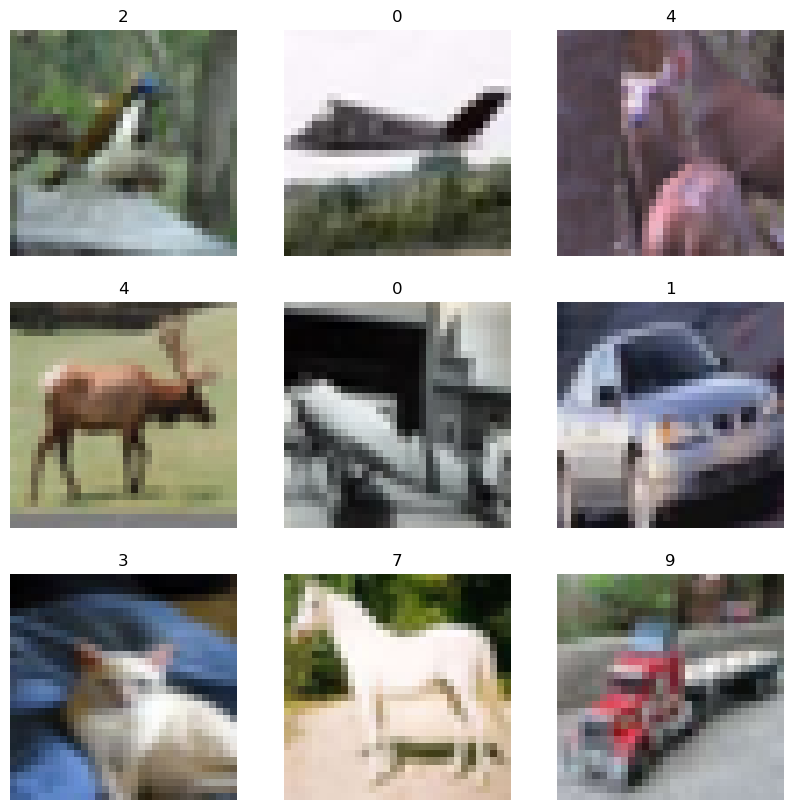

In [13]:
# Visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")